In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df, query_pg_df
import datetime
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import os
import glob
from functools import reduce

In [2]:
path = os.getcwd()+'/user_epoch/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

clean = []
csex = []
cage = []
cdf = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    if len(df['phase'].unique()) >= 4 : #and 0 in df['phase'].unique() and 1 in df['phase'].unique()
        if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):
                 
            cdf.append(df)
            demo_info = f.split("/")[-1].split('.')[0]
            csex.append(re.split('(\d+)',demo_info)[0])
            cage.append(int(re.split('(\d+)',demo_info)[1]))
            clean.append(int(f.split("/")[-1].split('.')[1][1:])) 

In [3]:
path = os.getcwd()+'/match_c_clean/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

mclean = []
mcsex = []
mcage = []
mcdf = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    #if len(df['phase'].unique()) >= 4: #and 0 in df['phase'].unique() and 1 in df['phase'].unique():
    #    if np.all([np.count_nonzero(df[df['phase']==ph]['rhr'].notna()) > 100 for ph in df['phase'].unique()]):
                
    mcdf.append(df)
    demo_info = f.split("/")[-1].split('.')[0]

    mclean.append(int(f.split("/")[-1].split('.')[1][1:]))  
    mcsex.append(re.split('(\d+)',demo_info)[0])
    mcage.append(int(re.split('(\d+)',demo_info)[1]))

                #df.to_csv('match_c_clean/'+demo_info+'.'+f.split("/")[-1].split('.')[1][1:]+'.csv')


In [4]:
path = os.getcwd()+'/match_neg_clean/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

nclean = []
ncsex = []
ncage = []
ncdf = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    #if len(df['phase'].unique()) >= 4: #and 0 in df['phase'].unique() and 1 in df['phase'].unique():
    #    if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):
                
    ncdf.append(df)
    demo_info = f.split("/")[-1].split('.')[0]

    nclean.append(int(f.split("/")[-1].split('.')[1][1:]))  
    ncsex.append(re.split('(\d+)',demo_info)[0])
    ncage.append(int(re.split('(\d+)',demo_info)[1]))
                #df.to_csv('match_neg_clean/'+demo_info+'.'+f.split("/")[-1].split('.')[1][1:]+'.csv')

In [5]:
nmatch_user = pd.DataFrame(data =  np.array([nclean, ncsex, ncage]).T,columns = ['uid', 'sex', 'age'])
perss_user = pd.DataFrame(data =  np.array([clean, csex, cage]).T,columns = ['uid', 'sex', 'age'])
match_user = pd.DataFrame(data =  np.array([mclean, mcsex, mcage]).T,columns = ['uid', 'sex', 'age'])     
perss_user['c'] = 1
match_user['c'] = 1
nmatch_user['c'] = 1

In [6]:
np.random.seed(2)
matched_idx = []
used = []
for p in range(len(perss_user.groupby(by=['age','sex']).sum())):
     
    val = perss_user.groupby(by=['age','sex']).sum().values[p][0]
    age = perss_user.groupby(by=['age','sex']).sum().index[p][0]
    sex = perss_user.groupby(by=['age','sex']).sum().index[p][1]
    mid = np.random.choice(match_user[(match_user.sex == sex)&(match_user.age == age)&(~match_user.uid.isin(used))].index,val * 3,replace=False)
    for i in match_user[match_user.index.isin(mid)].uid.values:
        used.append(i)
    for i in mid:
        matched_idx.append(i)

        
nmatched_idx = []
nused = []
for p in range(len(perss_user.groupby(by=['age','sex']).sum())):
     
    val = perss_user.groupby(by=['age','sex']).sum().values[p][0]
    age = perss_user.groupby(by=['age','sex']).sum().index[p][0]
    sex = perss_user.groupby(by=['age','sex']).sum().index[p][1]
    mid = np.random.choice(nmatch_user[(nmatch_user.sex == sex)&(nmatch_user.age == age)&(~nmatch_user.uid.isin(nused))].index,val * 3,replace=False)
    for i in nmatch_user[nmatch_user.index.isin(mid)].uid.values:
        nused.append(i)
    for i in mid:
        nmatched_idx.append(i)
#matched_idx = list(set(matched_idx ))  

In [7]:
seas = pd.read_csv('mean_rhr_pdps.csv',index_col=0)

In [8]:
def sliding_window(elements, window_size):
    wi_days = []
    for i in range(1,len(elements)+1):
        if i >= window_size:
            wi_days.append(elements[i-window_size:i])
        elif i < window_size:
            wi_days.append(elements[:i])
    return wi_days

In [9]:
def get_impact(subd):
    subd = subd.copy()
    subd['start'] = pd.to_datetime(subd['start'])
    subd = subd[subd['start'].notna()]
    if len(subd.dropna()) > 0:
 
   
        noimp = subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time())&((subd['steps'].isna())|(subd['steps'] == 0))]['hr'].dropna()
        
        loimp = subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time())&((subd['steps'].notna())&(subd['steps']>1)&(subd['steps']<=100))]['hr'].dropna()
        moimp = subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time())&((subd['steps'].notna())&(subd['steps']>100)&(subd['steps']<=500))]['hr'].dropna()
        hoimp = subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time())&((subd['steps'].notna())&(subd['steps']>500) )]['hr'].dropna()
         
         
        if len(noimp) >= 20  :
            return  noimp.mean(), loimp.mean(), moimp.mean(), hoimp.mean(), len(noimp)/len(subd['hr'].dropna()), len(loimp)/len(subd['hr'].dropna()), len(moimp)/len(subd['hr'].dropna()), len(hoimp)/len(subd['hr'].dropna())
        else:
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

In [ ]:
lcu_noimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(cdf)))
lcu_loimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(cdf)))
lcu_moimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(cdf)))
lcu_hoimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(cdf)))


n_noimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(cdf)))
n_loimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(cdf)))
n_moimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(cdf)))
n_hoimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(cdf)))
 
i =0
for ui in range(len(cdf)):# np.where(s_i & a_i)[0]:
    df = cdf[ui].copy()
    df = df[(pd.to_timedelta(df.day_totest).dt.days >= -62) &(pd.to_timedelta(df.day_totest).dt.days <= 180)]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    df = df.sort_values(by='date')
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    
    sc = df.source.unique()[0]
    seas_sc = seas[seas.source == sc].copy()
    seas_sc['date'] = pd.to_datetime(seas_sc['date'])
    df = df[['start','rhr','hr','steps','date','day_of_week', 'dt','day_totest', 'week_totest','phase']]
    df_seas = pd.merge(df,seas_sc, how = 'outer', on ='date')
    #df_seas = df_seas.dropna()
    df_seas['rhr_cl'] = df_seas['rhr'] - df_seas['mean']
    df_seas['hr_cl'] = df_seas['hr'] - df_seas['mean']
    #df['day_totest'] = df['date'] - df['dt']
    
    
    wi_list = sliding_window(df['date'].unique(),7)
    #dtt_list = sliding_window(df['day_totest'].unique(),7)
    for wi in range(len(wi_list)):
        nim, lim, mim, him, nnim, nlim, nmim, nhim = get_impact(df_seas[df_seas['date'].isin(wi_list[wi])])
        lcu_noimpact_mean.loc[df.day_totest.unique()[wi],i] =  nim  
        lcu_loimpact_mean.loc[df.day_totest.unique()[wi],i] =  lim  
        lcu_moimpact_mean.loc[df.day_totest.unique()[wi],i] =  mim  
        lcu_hoimpact_mean.loc[df.day_totest.unique()[wi],i] =  him  
        
        n_noimpact_mean.loc[df.day_totest.unique()[wi],i] =  nnim  
        n_loimpact_mean.loc[df.day_totest.unique()[wi],i] =  nlim  
        n_moimpact_mean.loc[df.day_totest.unique()[wi],i] =  nmim  
        n_hoimpact_mean.loc[df.day_totest.unique()[wi],i] =  nhim  
            
         
    i += 1
    


In [11]:
mu_noimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(matched_idx)))
mu_loimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(matched_idx)))
mu_moimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(matched_idx)))
mu_hoimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(matched_idx)))


mn_noimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(matched_idx)))
mn_loimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(matched_idx)))
mn_moimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(matched_idx)))
mn_hoimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(matched_idx)))
 
i =0
for ui in matched_idx:# np.where(s_i & a_i)[0]:
    df = mcdf[ui].copy()
    df = df[(pd.to_timedelta(df.day_totest).dt.days >= -62) &(pd.to_timedelta(df.day_totest).dt.days <= 180)]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    df = df.sort_values(by='date')
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    
    sc = df.source.unique()[0]
    seas_sc = seas[seas.source == sc].copy()
    seas_sc['date'] = pd.to_datetime(seas_sc['date'])
    df = df[['start','rhr','hr','steps','date','day_of_week', 'dt','day_totest', 'week_totest','phase']]
    df_seas = pd.merge(df,seas_sc, how = 'outer', on ='date')
    #df_seas = df_seas.dropna()
    df_seas['rhr_cl'] = df_seas['rhr'] - df_seas['mean']
    df_seas['hr_cl'] = df_seas['hr'] - df_seas['mean']
    #df['day_totest'] = df['date'] - df['dt']
    
    
    wi_list = sliding_window(df['date'].unique(),7)
    #dtt_list = sliding_window(df['day_totest'].unique(),7)
    for wi in range(len(wi_list)):
        nim, lim, mim, him, nnim, nlim, nmim, nhim = get_impact(df_seas[df_seas['date'].isin(wi_list[wi])])
        mu_noimpact_mean.loc[df.day_totest.unique()[wi],i] =  nim  
        mu_loimpact_mean.loc[df.day_totest.unique()[wi],i] =  lim  
        mu_moimpact_mean.loc[df.day_totest.unique()[wi],i] =  mim  
        mu_hoimpact_mean.loc[df.day_totest.unique()[wi],i] =  him  
        
        mn_noimpact_mean.loc[df.day_totest.unique()[wi],i] =  nnim  
        mn_loimpact_mean.loc[df.day_totest.unique()[wi],i] =  nlim  
        mn_moimpact_mean.loc[df.day_totest.unique()[wi],i] =  nmim  
        mn_hoimpact_mean.loc[df.day_totest.unique()[wi],i] =  nhim  
            
         
    i += 1
    


In [12]:
nu_noimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(nmatched_idx)))
nu_loimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(nmatched_idx)))
nu_moimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(nmatched_idx)))
nu_hoimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(nmatched_idx)))


nn_noimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(nmatched_idx)))
nn_loimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(nmatched_idx)))
nn_moimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(nmatched_idx)))
nn_hoimpact_mean = pd.DataFrame(index = pd.timedelta_range(datetime.timedelta(days = -62),datetime.timedelta(days = 180)), columns = range(len(nmatched_idx)))
 
i =0
for ui in nmatched_idx:# np.where(s_i & a_i)[0]:
    df = ncdf[ui].copy()
    df = df[(pd.to_timedelta(df.day_totest).dt.days >= -62) &(pd.to_timedelta(df.day_totest).dt.days <= 180)]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    df = df.sort_values(by='date')
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    
    sc = df.source.unique()[0]
    seas_sc = seas[seas.source == sc].copy()
    seas_sc['date'] = pd.to_datetime(seas_sc['date'])
    df = df[['start','rhr','hr','steps','date','day_of_week', 'dt','day_totest', 'week_totest','phase']]
    df_seas = pd.merge(df,seas_sc, how = 'outer', on ='date')
    #df_seas = df_seas.dropna()
    df_seas['rhr_cl'] = df_seas['rhr'] - df_seas['mean']
    df_seas['hr_cl'] = df_seas['hr'] - df_seas['mean']
    #df['day_totest'] = df['date'] - df['dt']
    
    
    wi_list = sliding_window(df['date'].unique(),7)
    #dtt_list = sliding_window(df['day_totest'].unique(),7)
    for wi in range(len(wi_list)):
        nim, lim, mim, him, nnim, nlim, nmim, nhim = get_impact(df_seas[df_seas['date'].isin(wi_list[wi])])
        nu_noimpact_mean.loc[df.day_totest.unique()[wi],i] =  nim  
        nu_loimpact_mean.loc[df.day_totest.unique()[wi],i] =  lim  
        nu_moimpact_mean.loc[df.day_totest.unique()[wi],i] =  mim  
        nu_hoimpact_mean.loc[df.day_totest.unique()[wi],i] =  him  
        
        nn_noimpact_mean.loc[df.day_totest.unique()[wi],i] =  nnim  
        nn_loimpact_mean.loc[df.day_totest.unique()[wi],i] =  nlim  
        nn_moimpact_mean.loc[df.day_totest.unique()[wi],i] =  nmim  
        nn_hoimpact_mean.loc[df.day_totest.unique()[wi],i] =  nhim  
            
         
    i += 1
    


In [13]:
plt.rcParams['font.size'] = 22

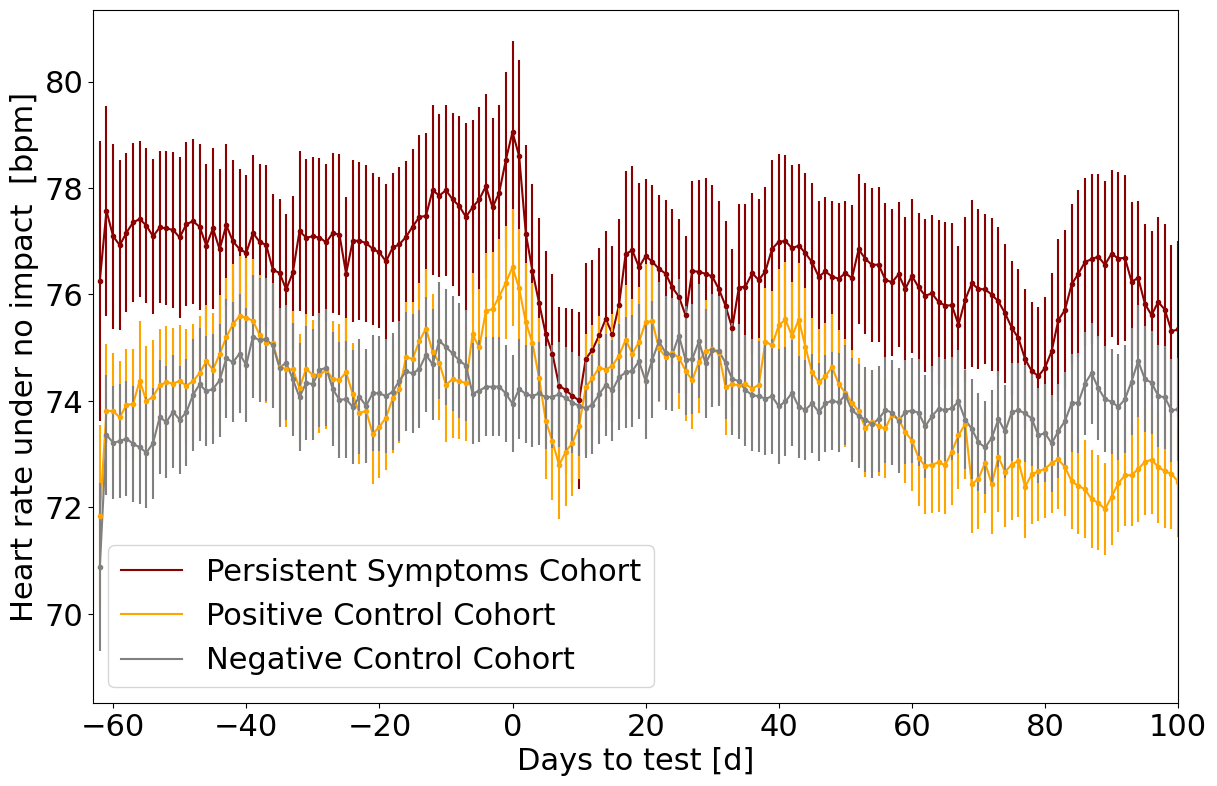

In [25]:
ldata_no = lcu_noimpact_mean #- lcu_noimpact_mean[lcu_noimpact_mean.index < pd.Timedelta(days=-7)].mean()
mdata_no = mu_noimpact_mean #- mu_noimpact_mean[mu_noimpact_mean.index < pd.Timedelta(days=-7)].mean()
ndata_no = nu_noimpact_mean #- nu_noimpact_mean[nu_noimpact_mean.index < pd.Timedelta(days=-7)].mean() 




plt.figure(figsize=(14,9))
plt.plot(ldata_no.index.days,ldata_no.mean(axis=1),c='darkred')
plt.plot(mdata_no.index.days,mdata_no.mean(axis=1),c='orange')
plt.plot(ndata_no.index.days,ndata_no.mean(axis=1),c='grey')
#plt.plot(data_no.index.days,data_ho.mean(axis=1),c='pink')
 
#plt.ylim(-4,3)
plt.xlim(-63,100)
plt.errorbar(ldata_no.index.days,ldata_no.mean(axis=1),yerr = ldata_no.std(axis=1)/np.sqrt(ldata_no.notna().sum(axis=1).values),c='darkred', fmt=".") 
plt.errorbar(mdata_no.index.days,mdata_no.mean(axis=1),yerr = mdata_no.std(axis=1)/np.sqrt(mdata_no.notna().sum(axis=1).values),c='orange', fmt=".") 
plt.errorbar(ndata_no.index.days,ndata_no.mean(axis=1),yerr = ndata_no.std(axis=1)/np.sqrt(ndata_no.notna().sum(axis=1).values),c='grey', fmt=".") 
#plt.errorbar(data_no.index.days,data_ho.mean(axis=1),yerr = data_ho.std(axis=1)/np.sqrt(data_ho.notna().sum(axis=1).values),c='pink', fmt=".") 
plt.xlabel('Days to test [d]')
plt.ylabel('Heart rate under no impact  [bpm]')
plt.legend(['Persistent Symptoms Cohort', 'Positive Control Cohort', 'Negative Control Cohort'],loc='lower left');#
plt.savefig('figures_pap/hrnoimp.png',dpi=300, bbox_inches="tight")

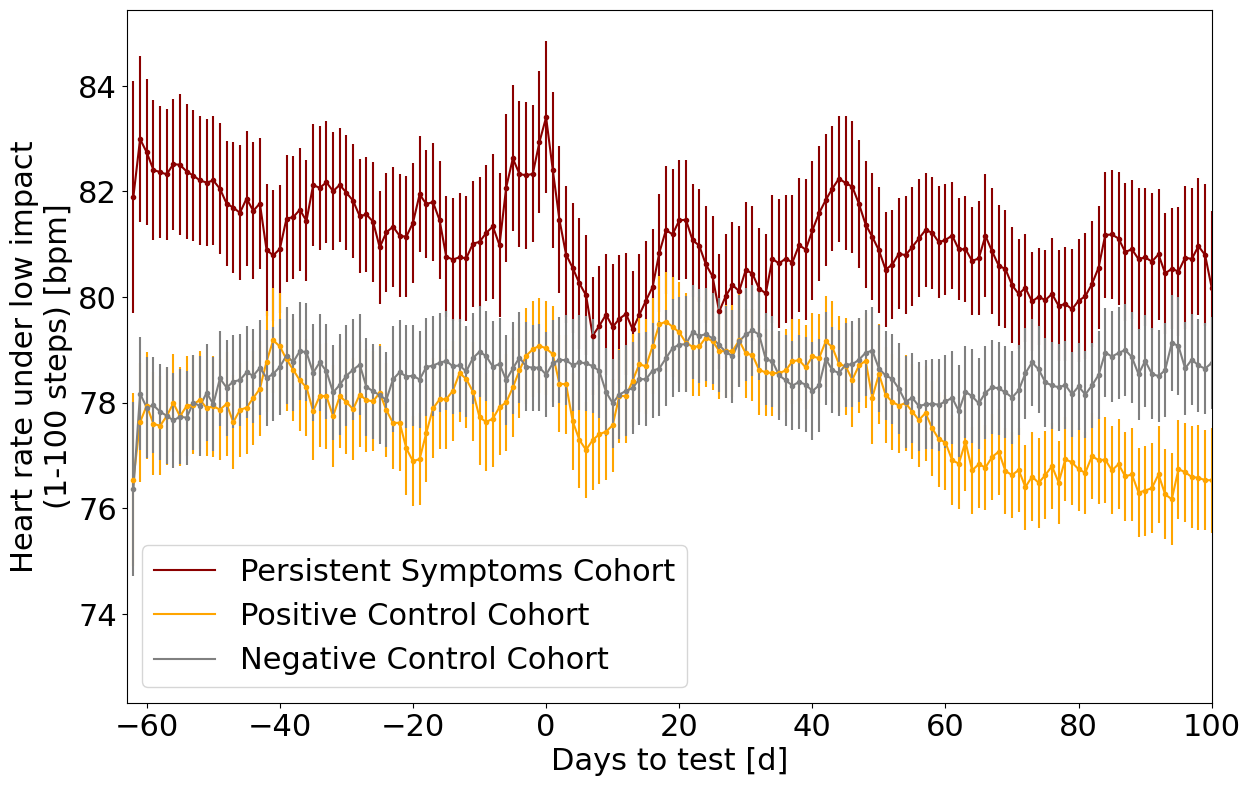

In [23]:
ldata_lo = lcu_loimpact_mean #- lcu_loimpact_mean[lcu_loimpact_mean.index < pd.Timedelta(days=-7)].mean()
mdata_lo = mu_loimpact_mean #- mu_loimpact_mean[mu_loimpact_mean.index < pd.Timedelta(days=-7)].mean()
ndata_lo = nu_loimpact_mean #- nu_loimpact_mean[nu_loimpact_mean.index < pd.Timedelta(days=-7)].mean() 




plt.figure(figsize=(14,9))
plt.plot(ldata_lo.index.days,ldata_lo.mean(axis=1),c='darkred')
plt.plot(mdata_lo.index.days,mdata_lo.mean(axis=1),c='orange')
plt.plot(ndata_lo.index.days,ndata_lo.mean(axis=1),c='grey')
#plt.plot(data_no.index.days,data_ho.mean(axis=1),c='pink')
 
#plt.ylim(-4,3)
plt.xlim(-63,100)
plt.errorbar(ldata_lo.index.days,ldata_lo.mean(axis=1),yerr = ldata_lo.std(axis=1)/np.sqrt(ldata_lo.notna().sum(axis=1).values),c='darkred', fmt=".") 
plt.errorbar(mdata_lo.index.days,mdata_lo.mean(axis=1),yerr = mdata_lo.std(axis=1)/np.sqrt(mdata_lo.notna().sum(axis=1).values),c='orange', fmt=".") 
plt.errorbar(ndata_lo.index.days,ndata_lo.mean(axis=1),yerr = ndata_lo.std(axis=1)/np.sqrt(ndata_lo.notna().sum(axis=1).values),c='grey', fmt=".") 
#plt.errorbar(data_no.index.days,data_ho.mean(axis=1),yerr = data_ho.std(axis=1)/np.sqrt(data_ho.notna().sum(axis=1).values),c='pink', fmt=".") 
plt.xlabel('Days to test [d]')
plt.ylabel(r'Heart rate under low impact'+'\n'+'(1-100 steps) [bpm]')
plt.legend(['Persistent Symptoms Cohort', 'Positive Control Cohort', 'Negative Control Cohort'],loc='lower left');#
plt.savefig('figures_pap/hrloimp.png',dpi=300, bbox_inches="tight")

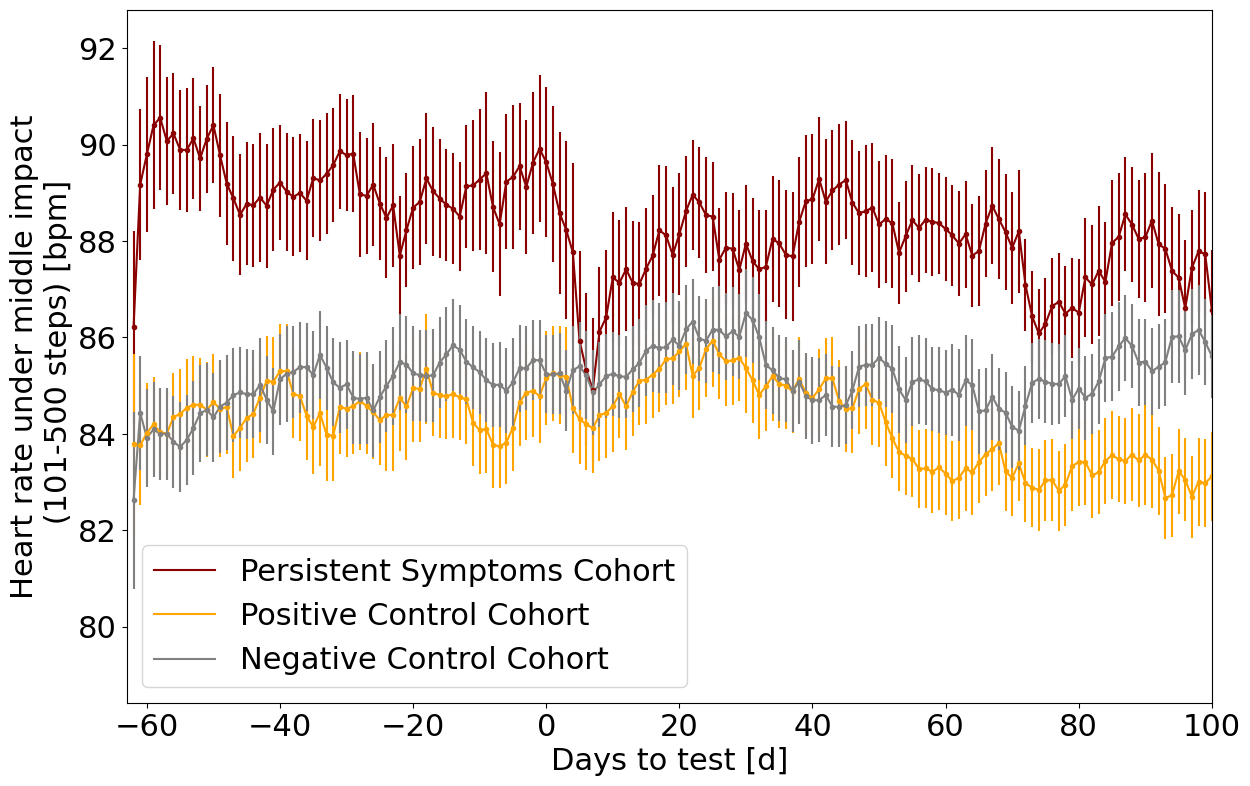

In [19]:
ldata_mo = lcu_moimpact_mean #- lcu_moimpact_mean[lcu_moimpact_mean.index < pd.Timedelta(days=-7)].mean()
mdata_mo = mu_moimpact_mean #- mu_moimpact_mean[mu_moimpact_mean.index < pd.Timedelta(days=-7)].mean()
ndata_mo = nu_moimpact_mean #- nu_moimpact_mean[nu_moimpact_mean.index < pd.Timedelta(days=-7)].mean() 




plt.figure(figsize=(14,9))
plt.plot(ldata_mo.index.days,ldata_mo.mean(axis=1),c='darkred')
plt.plot(mdata_mo.index.days,mdata_mo.mean(axis=1),c='orange')
plt.plot(ndata_mo.index.days,ndata_mo.mean(axis=1),c='grey')
#plt.plot(data_no.index.days,data_ho.mean(axis=1),c='pink')
 
#plt.ylim(-4,3)
plt.xlim(-63,100)
plt.errorbar(ldata_mo.index.days,ldata_mo.mean(axis=1),yerr = ldata_mo.std(axis=1)/np.sqrt(ldata_mo.notna().sum(axis=1).values),c='darkred', fmt=".") 
plt.errorbar(mdata_mo.index.days,mdata_mo.mean(axis=1),yerr = mdata_mo.std(axis=1)/np.sqrt(mdata_mo.notna().sum(axis=1).values),c='orange', fmt=".") 
plt.errorbar(ndata_mo.index.days,ndata_mo.mean(axis=1),yerr = ndata_mo.std(axis=1)/np.sqrt(ndata_mo.notna().sum(axis=1).values),c='grey', fmt=".") 
#plt.errorbar(data_no.index.days,data_ho.mean(axis=1),yerr = data_ho.std(axis=1)/np.sqrt(data_ho.notna().sum(axis=1).values),c='pink', fmt=".") 
plt.xlabel('Days to test [d]')
plt.ylabel(r'Heart rate under middle impact'+'\n'+' (101-500 steps) [bpm]')
plt.legend(['Persistent Symptoms Cohort', 'Positive Control Cohort', 'Negative Control Cohort'],loc='lower left');#
plt.savefig('figures_pap/hrmoimp.png',dpi=300, bbox_inches="tight")

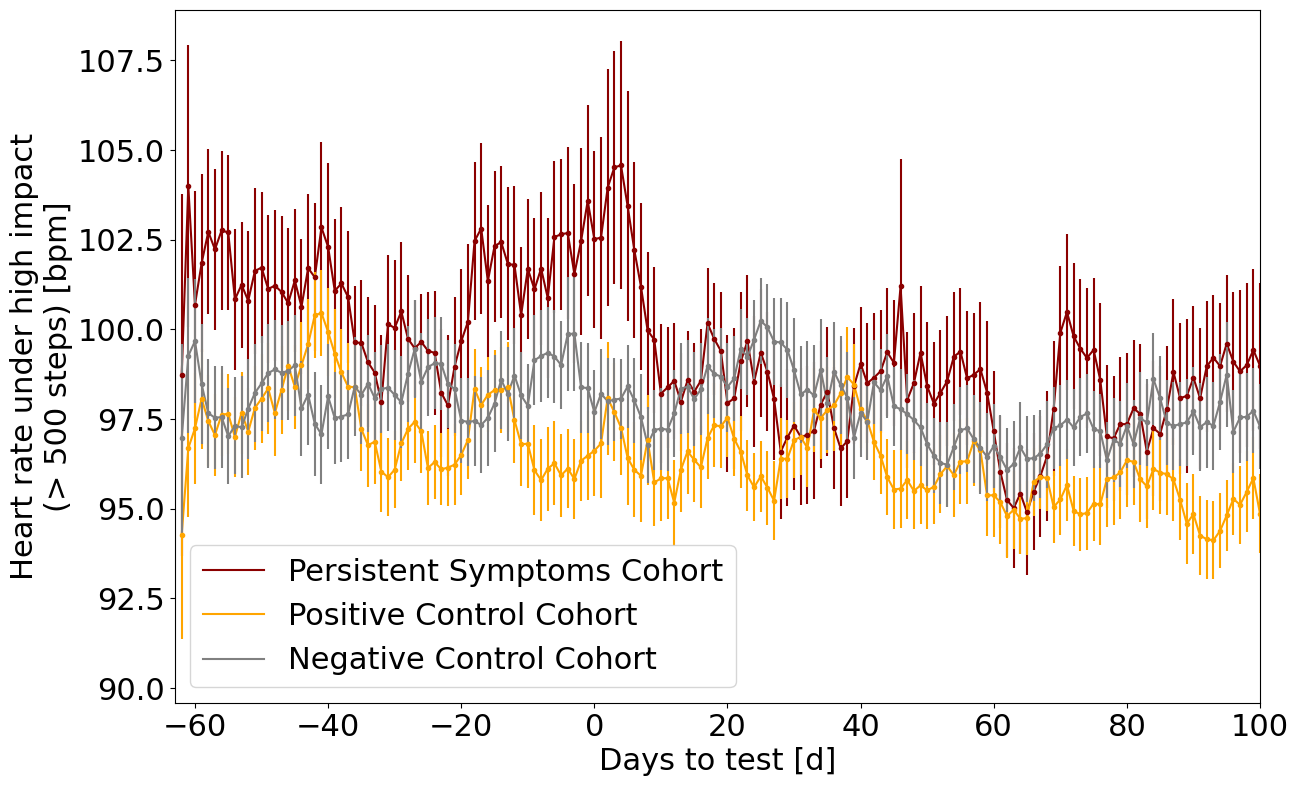

In [26]:
ldata_ho = lcu_hoimpact_mean #- lcu_moimpact_mean[lcu_moimpact_mean.index < pd.Timedelta(days=-7)].mean()
mdata_ho = mu_hoimpact_mean #- mu_moimpact_mean[mu_moimpact_mean.index < pd.Timedelta(days=-7)].mean()
ndata_ho = nu_hoimpact_mean #- nu_moimpact_mean[nu_moimpact_mean.index < pd.Timedelta(days=-7)].mean() 




plt.figure(figsize=(14,9))
plt.plot(ldata_ho.index.days,ldata_ho.mean(axis=1),c='darkred')
plt.plot(mdata_ho.index.days,mdata_ho.mean(axis=1),c='orange')
plt.plot(ndata_ho.index.days,ndata_ho.mean(axis=1),c='grey')
#plt.plot(data_no.index.days,data_ho.mean(axis=1),c='pink')
 
#plt.ylim(-4,3)
plt.xlim(-63,100)
plt.errorbar(ldata_ho.index.days,ldata_ho.mean(axis=1),yerr = ldata_ho.std(axis=1)/np.sqrt(ldata_ho.notna().sum(axis=1).values),c='darkred', fmt=".") 
plt.errorbar(mdata_ho.index.days,mdata_ho.mean(axis=1),yerr = mdata_ho.std(axis=1)/np.sqrt(mdata_ho.notna().sum(axis=1).values),c='orange', fmt=".") 
plt.errorbar(ndata_ho.index.days,ndata_ho.mean(axis=1),yerr = ndata_ho.std(axis=1)/np.sqrt(ndata_ho.notna().sum(axis=1).values),c='grey', fmt=".") 
#plt.errorbar(data_no.index.days,data_ho.mean(axis=1),yerr = data_ho.std(axis=1)/np.sqrt(data_ho.notna().sum(axis=1).values),c='pink', fmt=".") 
plt.xlabel('Days to test [d]')
plt.ylabel(r'Heart rate under high impact'+'\n'+'(> 500 steps) [bpm]')
plt.legend(['Persistent Symptoms Cohort', 'Positive Control Cohort', 'Negative Control Cohort'],loc='lower left');#
plt.savefig('figures_pap/hrhoimp.png',dpi=300, bbox_inches="tight")

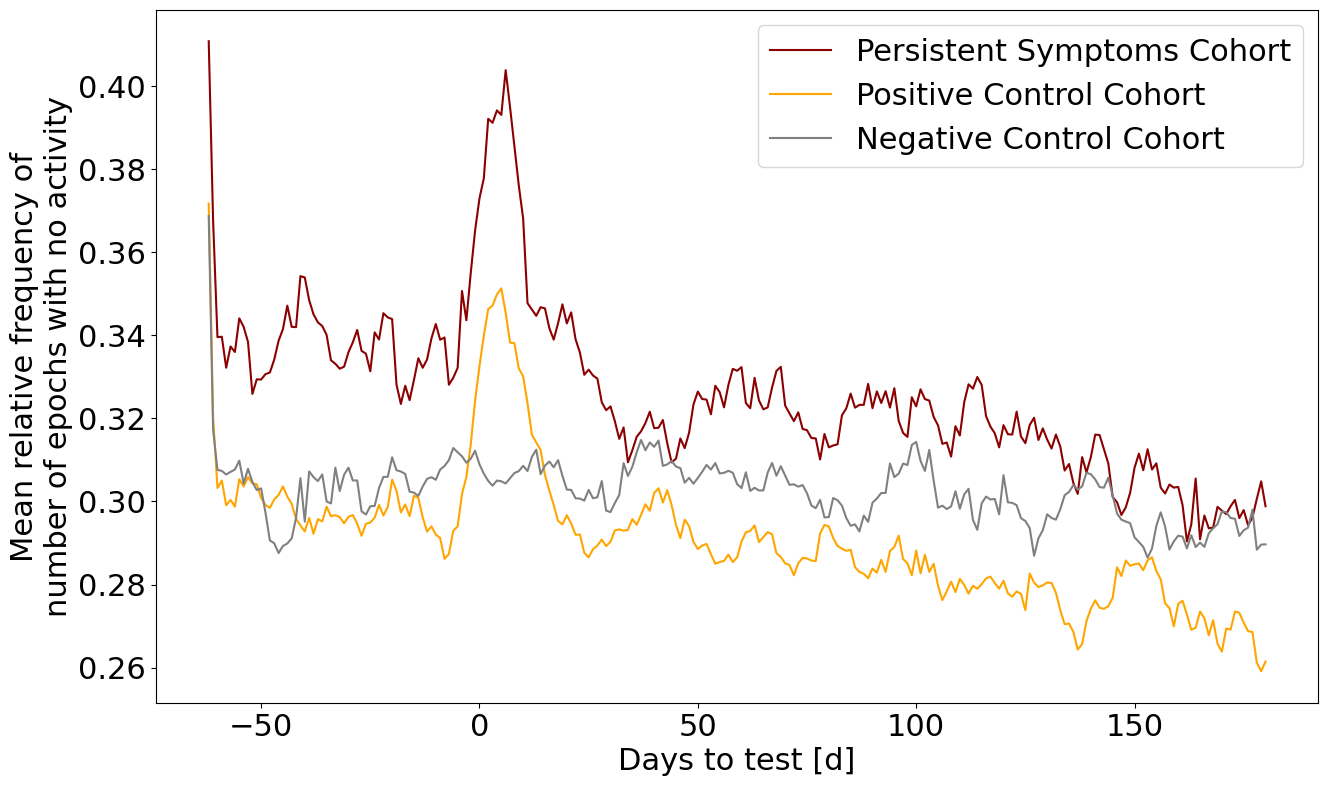

In [31]:
plt.figure(figsize=(15,9))
 
plt.plot(n_noimpact_mean.index.days, n_noimpact_mean.mean(axis=1),c='darkred')
plt.plot(mn_noimpact_mean.index.days, mn_noimpact_mean.mean(axis=1),c='orange')
plt.plot(nn_noimpact_mean.index.days, nn_noimpact_mean.mean(axis=1),c='grey') 
plt.ylabel(r'Mean relative frequency of'+'\n'+'number of epochs with no activity')
plt.legend(['Persistent Symptoms Cohort', 'Positive Control Cohort', 'Negative Control Cohort']);#
plt.xlabel('Days to test [d]');

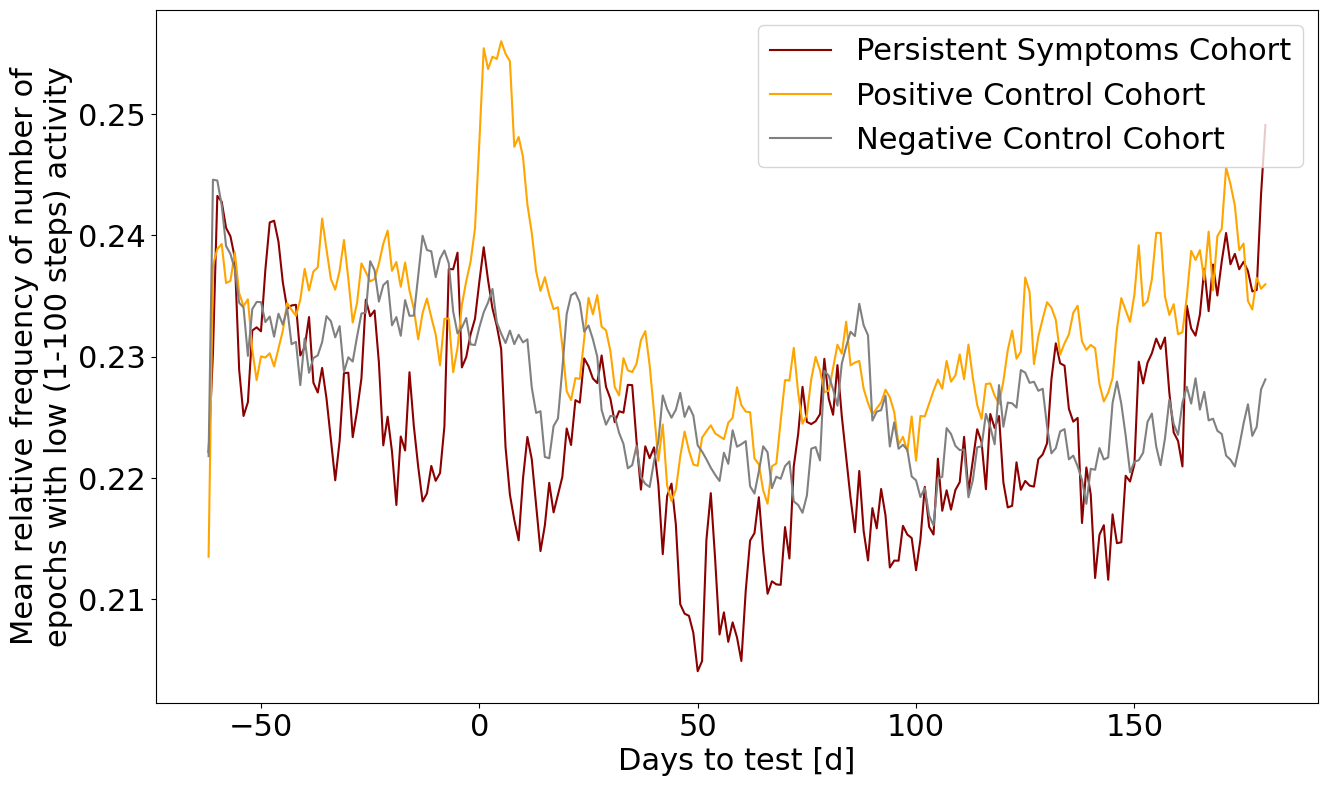

In [32]:
plt.figure(figsize=(15,9))
 
plt.plot(n_loimpact_mean.index.days, n_loimpact_mean.mean(axis=1),c='darkred')
plt.plot(mn_loimpact_mean.index.days, mn_loimpact_mean.mean(axis=1),c='orange')
plt.plot(nn_loimpact_mean.index.days, nn_loimpact_mean.mean(axis=1),c='grey') 
plt.ylabel(r'Mean relative frequency of number of'+'\n'+'epochs with low (1-100 steps) activity')
plt.legend(['Persistent Symptoms Cohort', 'Positive Control Cohort', 'Negative Control Cohort']);#
plt.xlabel('Days to test [d]');

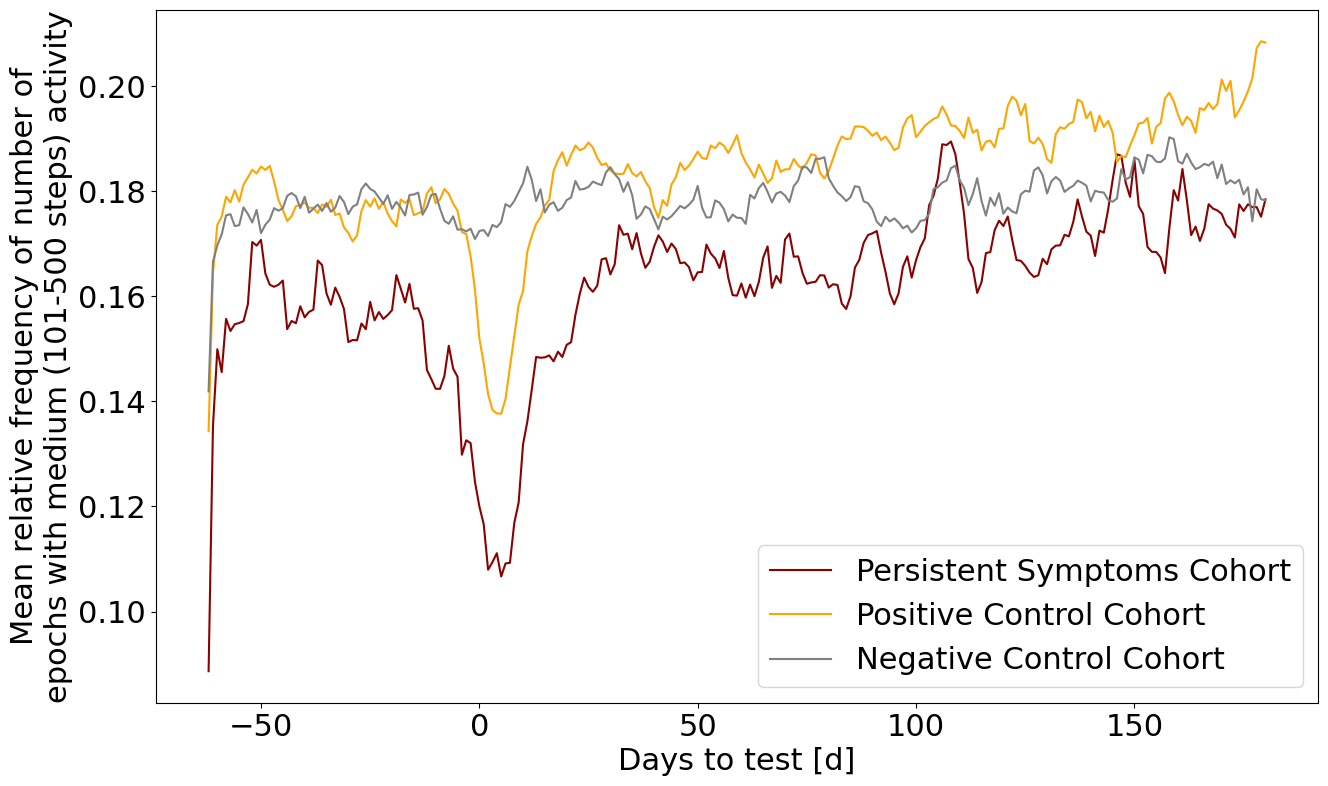

In [33]:
plt.figure(figsize=(15,9))
 
plt.plot(n_moimpact_mean.index.days, n_moimpact_mean.mean(axis=1),c='darkred')
plt.plot(mn_moimpact_mean.index.days, mn_moimpact_mean.mean(axis=1),c='orange')
plt.plot(nn_moimpact_mean.index.days, nn_moimpact_mean.mean(axis=1),c='grey') 
plt.ylabel(r'Mean relative frequency of number of'+'\n'+'epochs with medium (101-500 steps) activity')
plt.legend(['Persistent Symptoms Cohort', 'Positive Control Cohort', 'Negative Control Cohort']);#
plt.xlabel('Days to test [d]');

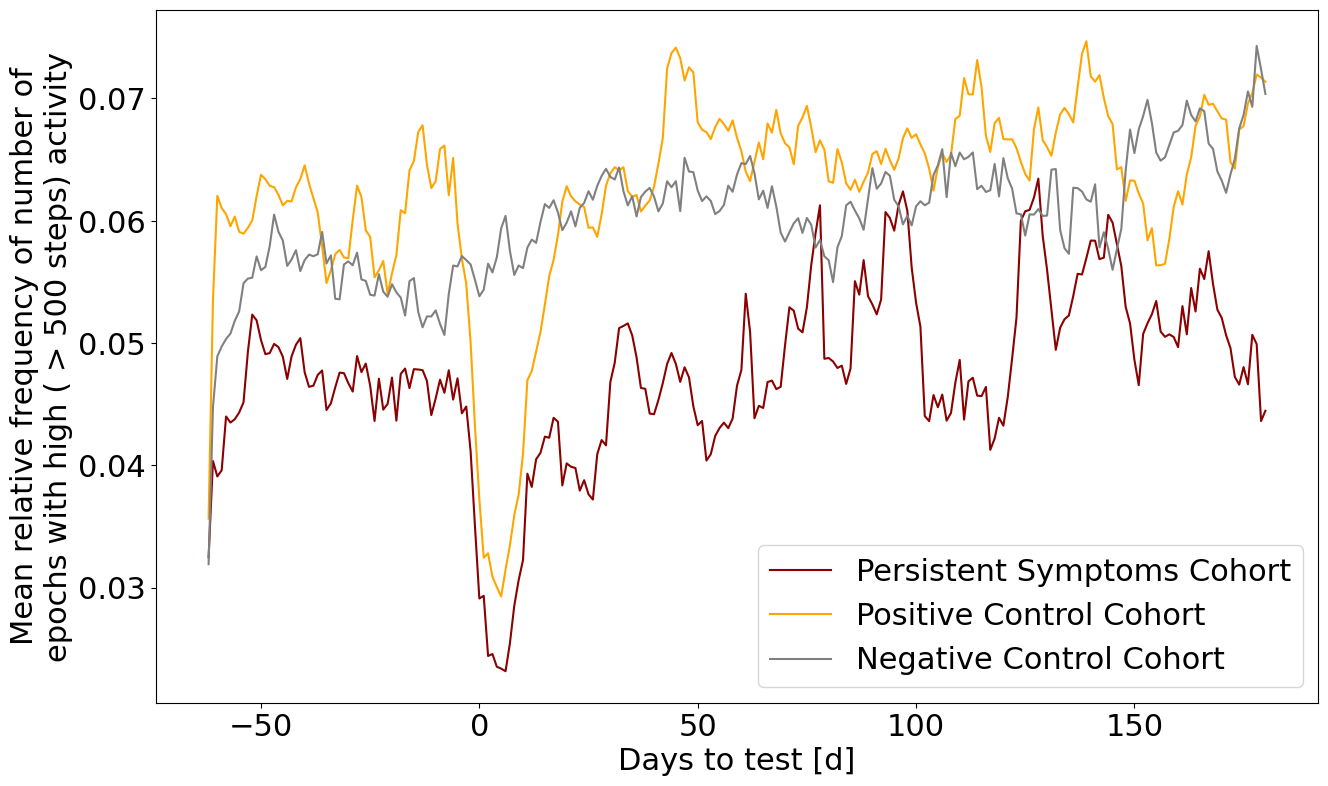

In [34]:
plt.figure(figsize=(15,9))
 
plt.plot(n_hoimpact_mean.index.days, n_hoimpact_mean.mean(axis=1),c='darkred')
plt.plot(mn_hoimpact_mean.index.days, mn_hoimpact_mean.mean(axis=1),c='orange')
plt.plot(nn_hoimpact_mean.index.days, nn_hoimpact_mean.mean(axis=1),c='grey') 
plt.ylabel(r'Mean relative frequency of number of'+'\n'+'epochs with high ( > 500 steps) activity')
plt.legend(['Persistent Symptoms Cohort', 'Positive Control Cohort', 'Negative Control Cohort']);#
plt.xlabel('Days to test [d]');

In [ ]:
data_no = lcu_noimpact_mean - lcu_noimpact_mean[lcu_noimpact_mean.index < pd.Timedelta(days=-7)].mean()
data_lo = lcu_loimpact_mean - lcu_loimpact_mean[lcu_loimpact_mean.index < pd.Timedelta(days=-7)].mean()
data_mo = lcu_moimpact_mean - lcu_moimpact_mean[lcu_moimpact_mean.index < pd.Timedelta(days=-7)].mean()
#data_ho = lcu_hoimpact_mean - lcu_hoimpact_mean[lcu_hoimpact_mean.index < pd.Timedelta(days=-7)].mean()




plt.figure(figsize=(12,6))
plt.plot(data_no.index.days,data_no.mean(axis=1),c='darkred')
plt.plot(data_no.index.days,data_lo.mean(axis=1),c='red')
plt.plot(data_no.index.days,data_mo.mean(axis=1),c='orange')
#plt.plot(data_no.index.days,data_ho.mean(axis=1),c='pink')
 
#plt.ylim(-4,3)
plt.xlim(-63,100)
plt.errorbar(data_no.index.days,data_no.mean(axis=1),yerr = data_no.std(axis=1)/np.sqrt(data_no.notna().sum(axis=1).values),c='darkred', fmt=".") 
plt.errorbar(data_no.index.days,data_lo.mean(axis=1),yerr = data_lo.std(axis=1)/np.sqrt(data_lo.notna().sum(axis=1).values),c='red', fmt=".") 
plt.errorbar(data_no.index.days,data_mo.mean(axis=1),yerr = data_mo.std(axis=1)/np.sqrt(data_mo.notna().sum(axis=1).values),c='orange', fmt=".") 
#plt.errorbar(data_no.index.days,data_ho.mean(axis=1),yerr = data_ho.std(axis=1)/np.sqrt(data_ho.notna().sum(axis=1).values),c='pink', fmt=".") 
plt.xlabel('days to test [d]')
plt.ylabel('hr  relative to healthy window')
plt.legend(['No impact (0 steps)','Low impact (1-100 steps)','Middle impact (101-500 steps)']);#,'High impact (> 500 steps)',

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(n_hoimpact_mean.index.days, n_noimpact_mean.mean(axis=1),c='darkred')
plt.plot(n_hoimpact_mean.index.days, n_loimpact_mean.mean(axis=1),c='red')
plt.plot(n_hoimpact_mean.index.days, n_moimpact_mean.mean(axis=1),c='orange')
plt.plot(n_hoimpact_mean.index.days, n_hoimpact_mean.mean(axis=1),c='pink')
plt.ylabel('mean relative frequency of number of epochs with activity n')
plt.legend(['No impact (0 steps)','Low impact (1-100 steps)','Middle impact (101-500 steps)','High impact (> 500 steps)',]);

In [ ]:
n_moimpact_mean.mean(axis=1)

In [ ]:
 
plt.plot(mu_lowimpact_mean.index.days,mu_lowimpact_mean.notna().sum(axis=1),c='orange')
 
plt.ylabel('# user')
plt.xlim(-63,100)
plt.xlabel('days to test');